# Проект 2. Разведывательный анализ данных.

## План работы

1. Загрузка библиотек и данных
2. Анализ номинативных переменных
3. Анализ количественных переменных
4. Заполнение пробелов в выбранных переменных
5. Корреляционный анализ с учетом заполненных пробелов
6. Выводы

## Подход в обработке и анализе данных

1. Значение score имеют очень важное значение, поэтому данные без оценки я не рассматриваю, убираю их.
2. Использую попарное сопоставление исследуемого столбца со значениями score. При попарной выборке убираю пропуски и сильные выбросы. Считаю корреляцию и p-value. Параллельно проверяю попарную корреляцию. И убираю явно лишнее.
3. Для номинатиных переменных делаю тоже самое, заменив номинативные переменнные на численные. Для этого создаю список уникальных значений. И в качестве значения беру индекс перемнной в этом списке. Это позволяет достаточно быстро обработать все данные и сделать выводы. 
4. Для номинативных данных использую и второй вариант, сравнение значений средних score по группам значений в столбце. Отбираю и анализирую переменные более подробно.
5. Кроме этого для этих переменных построены боксплоты со score, где наглядно выдны те переменные, которые не влияют на score существенным образом.
6. Сузив список переменных, занимаюсь более детальным анализом оставшихся данных с заполнением пропусков. Далее провожу итоговый корреляционный анализ.
7. Для заполнения пропусков использованы разные подходы. Так, в столбце адрес заполнение в зависимости от того, куда ближе значение к среднему по U или среднему по R. В каких то случаях заполнено по среднему, в каких-то по наиболее часто встречающемуся. Явные выбросы исправлены на среднее. Где есть выбросы по сравнению с межквартильным размахом, но все в пределах референсных значений все оставлено, как есть.
8. В качестве границы отсечения взято p-value = 0.05.

## 1. Загрузка библиотек и данных

In [1]:
import pandas as pd
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('stud_math.csv')
stud = data[data.score>0]

In [2]:
stud.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [3]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               352 non-null    object 
 1   sex                  352 non-null    object 
 2   age                  352 non-null    int64  
 3   address              338 non-null    object 
 4   famsize              328 non-null    object 
 5   Pstatus              311 non-null    object 
 6   Medu                 350 non-null    float64
 7   Fedu                 331 non-null    float64
 8   Mjob                 335 non-null    object 
 9   Fjob                 320 non-null    object 
 10  reason               337 non-null    object 
 11  guardian             323 non-null    object 
 12  traveltime           329 non-null    float64
 13  studytime            345 non-null    float64
 14  failures             332 non-null    float64
 15  schoolsup            343 non-null    obj

Видим, что из 31 столбца есть как количественные, которые можно замерить, так и другие. Рассмотрим сначала номинативные переменные.

## 2. Анализ номинативных переменных

In [4]:
# выбираем столбцы с неноминативными данными
studd=stud.select_dtypes(include = ['object'])
# добавляем столбец с оценками
studd=studd.copy()
studd['score']=stud['score']
studd

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,score
0,GP,F,U,NaN,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,NaN,no,30.0
1,GP,F,U,GT3,NaN,at_home,other,course,father,no,yes,no,no,no,yes,yes,no,30.0
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,NaN,no,yes,yes,yes,NaN,50.0
3,GP,F,U,GT3,T,health,NaN,home,mother,no,yes,yes,yes,yes,yes,yes,yes,75.0
4,GP,F,U,GT3,T,other,other,home,father,no,yes,yes,no,yes,yes,no,no,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,U,LE3,A,services,services,course,NaN,no,yes,yes,no,yes,yes,no,no,45.0
391,MS,M,U,LE3,T,services,services,course,mother,no,no,no,no,no,yes,yes,no,80.0
392,MS,M,R,GT3,T,other,other,course,NaN,NaN,no,no,no,no,NaN,no,no,35.0
393,MS,M,R,LE3,T,services,other,course,mother,no,no,no,NaN,no,yes,yes,no,50.0


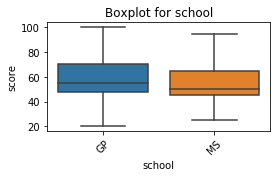

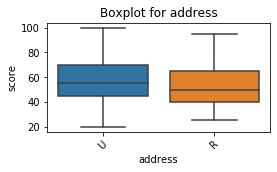

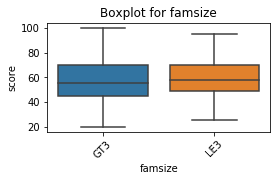

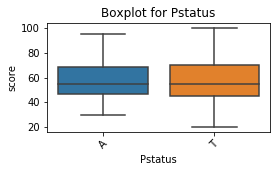

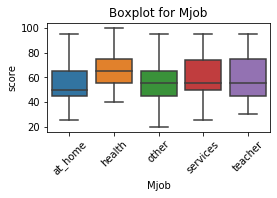

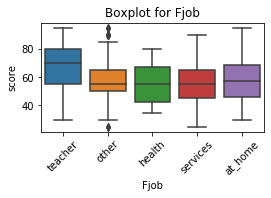

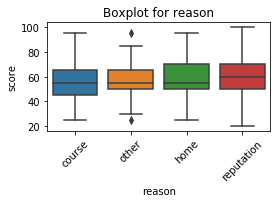

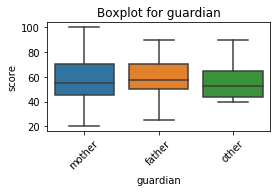

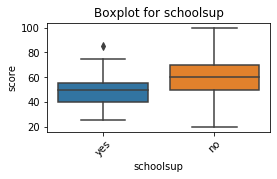

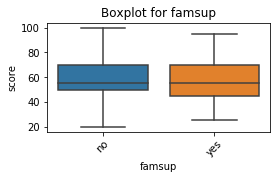

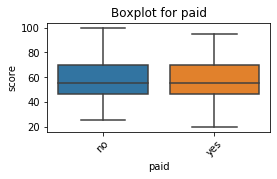

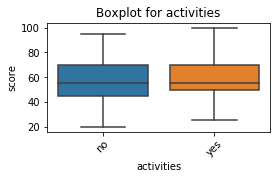

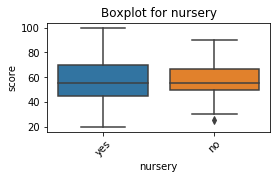

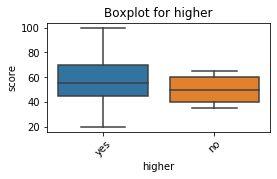

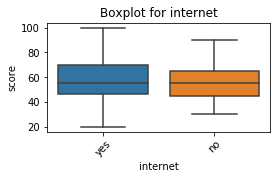

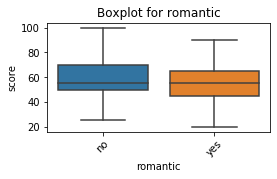

In [5]:
# пробуем посмотреть боксплоты
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (4, 2))
    sns.boxplot(x=column, y='score', 
                data=studd.loc[studd.loc[:, column].isin(studd.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

for col in ['school','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']:
    get_boxplot(col)

Глядя на графики можно выделить группу переменных, которые точно не интересны: school, famsize, Pstatus,famsup, paid, activities, nursery, internet, romantic

In [6]:
# первое колличественное приближение: считаем среднее score по значениям в столбцах
# для этого выбираем попарно столцы, убираем пустые значения функцией dropna, 
# группируем по значениям и считаем среднее score
# далее считаю отношение между максимальным и минимальным значением
# получается размах в разбросе значений
# чем больше размах, тем существеннee фактор
col=studd.columns.tolist()
for i in col[:-1]:
    c=studd[[i,'score']]
    c=c.dropna()
    mn=round(c.groupby(i)['score'].mean().min(),0)
    mx=round(c.groupby(i)['score'].mean().max(),0)
    raz=round(mx/mn,2)
    print(i,mn,mx,raz)

school 54.0 58.0 1.07
sex 56.0 59.0 1.05
address 53.0 59.0 1.11
famsize 58.0 58.0 1.0
Pstatus 57.0 58.0 1.02
Mjob 54.0 65.0 1.2
Fjob 56.0 67.0 1.2
reason 57.0 59.0 1.04
guardian 55.0 59.0 1.07
schoolsup 48.0 60.0 1.25
famsup 57.0 59.0 1.04
paid 58.0 58.0 1.0
activities 57.0 59.0 1.04
nursery 57.0 58.0 1.02
higher 49.0 58.0 1.18
internet 55.0 58.0 1.05
romantic 56.0 59.0 1.05


In [7]:
# рассмотрим подробнее наиболее интересные из них со значением от 1.1
col=studd.columns.tolist()
for i in col[:-1]:
    c=studd[[i,'score']]
    c=c.dropna()
    mn=round(c.groupby(i)['score'].mean().min(),0)
    mx=round(c.groupby(i)['score'].mean().max(),0)
    raz=round(mx/mn,2)
    if raz>1.1:
        print(i,mn,mx,raz)
        print(c[i].value_counts())
        print()
    else:
        continue

address 53.0 59.0 1.11
U    265
R     73
Name: address, dtype: int64

Mjob 54.0 65.0 1.2
other       115
services     90
teacher      51
at_home      49
health       30
Name: Mjob, dtype: int64

Fjob 56.0 67.0 1.2
other       176
services     89
teacher      26
health       15
at_home      14
Name: Fjob, dtype: int64

schoolsup 48.0 60.0 1.25
no     295
yes     48
Name: schoolsup, dtype: int64

higher 49.0 58.0 1.18
yes    320
no      13
Name: higher, dtype: int64



Выводы: интересные переменные для построения модели address, Mjob, Fjob, schoolsup, higher. Переменные address и schoolsup имеет смысл серьезно рассматривать. Переменная higher дает хороший разброс, но поскольку соотношение между да и нет 320 на 13, слишком большое, то этот показатель имеет значение лишь для 3,9% учеников, что сопоставимо с ошибкой, поэтому для построения модели переменная не годится. 

In [8]:
print(studd.groupby(studd['Mjob'])['score'].mean())
print(studd['Mjob'].value_counts())

Mjob
at_home     54.081633
health      64.666667
other       54.695652
services    59.611111
teacher     59.509804
Name: score, dtype: float64
other       115
services     90
teacher      51
at_home      49
health       30
Name: Mjob, dtype: int64


Здесь картина тоже не ровная. Максимальное значение в группе health. Но здесь мало значений. Нижняя граница близка по значениям в группах at_home и other. Если убрать health, то размах будет меньше 1.1. Думаю эту переменную в таком виде применять нельзя. 

In [9]:
print(studd.groupby(studd['Fjob'])['score'].mean())
print(studd['Fjob'].value_counts())

Fjob
at_home     59.285714
health      55.666667
other       56.676136
services    56.123596
teacher     66.730769
Name: score, dtype: float64
other       176
services     89
teacher      26
health       15
at_home      14
Name: Fjob, dtype: int64


Здесь картина тоже не ровная. Минимальное значение в группе health. Но здесь мало значений. Верхняя граница в группе teacher. Если убрать health и teacher, то размах будет меньше 1.1. Думаю и эту переменную в таком виде применять нельзя. 

### Итак, двумя используя разные способы выбраны существенные параметры, влияющие на итоговые оценки: address, schoolsup

In [10]:
# первое приближение: ищем попарную кореляцию для каждого столбца со столбцом score,
# для этого выбираем попарно столцы, убираем пустые значения функцией dropna, 
# для искомого столбца создаем список уникальных значений,
# заменяем переменные на числа (индекс из списка уникальных значений),
# считаем корреляцию и p-value, печатаем кореляцию и число уникальных значений в столбце
b=[]
col=studd.columns.tolist()
for i in col[:-1]:
    c=studd[[i,'score']]
    c=c.dropna()
    b=c.loc[:,i].unique().tolist()
    c.loc[:,i]=c.loc[:,i].apply(lambda x: b.index(x))
    cor1=pearsonr(c[i],c['score'])
    print(i, cor1, 'уникальных значений -', len(b))

school (-0.0782690455754843, 0.1427891363668696) уникальных значений - 2
sex (0.10244884961175449, 0.05481629433222803) уникальных значений - 2
address (-0.13823027161071189, 0.0109546305006273) уникальных значений - 2
famsize (0.025483537967396427, 0.645631620926334) уникальных значений - 2
Pstatus (-0.017252199409964107, 0.7618568738621495) уникальных значений - 2
Mjob (0.07702856979775093, 0.15952367972285875) уникальных значений - 5
Fjob (-0.07648293312851512, 0.1723114806136191) уникальных значений - 5
reason (0.06432090617063517, 0.2389531489739978) уникальных значений - 4
guardian (-0.018639757675283215, 0.7385850301300904) уникальных значений - 3
schoolsup (0.24979583852111858, 2.8152819921389103e-06) уникальных значений - 2
famsup (-0.04687402323368412, 0.40630966502705) уникальных значений - 2
paid (-0.022039155749190277, 0.6963358441019494) уникальных значений - 2
activities (0.060008079805620375, 0.2698473955621192) уникальных значений - 2
nursery (-0.02989071576832308, 0.5

In [11]:
# Посмотрим на столбцы, где число уникальных значений больше двух. Для примера Mjob и reason.
# группировка по признаку со средней оценкой score по группе
print(studd.groupby(['Mjob'])['score'].mean())
print(studd.groupby(['reason'])['score'].mean())

Mjob
at_home     54.081633
health      64.666667
other       54.695652
services    59.611111
teacher     59.509804
Name: score, dtype: float64
reason
course        56.512605
home          58.089888
other         57.575758
reputation    59.114583
Name: score, dtype: float64


Что мы видим, выше баллы у тех учеников, чьи мамы работают врачами.
Также оценки выше, если школа выбрана по репутации. Ниже, если школа общеобразовательная.
Но эти различия не дают существенную корреляцию.

## 3. Анализ количественных переменных

In [12]:
# выборка количественных данных
st=stud.select_dtypes(include = ['float64', 'int64'])
st.head()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
0,18,4.0,4.0,2.0,2.0,0.0,-6.0,4.0,3.0,4.0,3.0,6.0,30.0
1,17,1.0,1.0,1.0,2.0,0.0,-6.0,5.0,3.0,3.0,3.0,4.0,30.0
2,15,1.0,1.0,1.0,2.0,3.0,-6.0,4.0,3.0,2.0,3.0,10.0,50.0
3,15,4.0,2.0,1.0,3.0,0.0,-9.0,3.0,2.0,2.0,5.0,2.0,75.0
4,16,3.0,3.0,1.0,2.0,0.0,-6.0,4.0,3.0,2.0,5.0,4.0,50.0


In [13]:
st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  352 non-null    int64  
 1   Medu                 350 non-null    float64
 2   Fedu                 331 non-null    float64
 3   traveltime           329 non-null    float64
 4   studytime            345 non-null    float64
 5   failures             332 non-null    float64
 6   studytime, granular  345 non-null    float64
 7   famrel               328 non-null    float64
 8   freetime             344 non-null    float64
 9   goout                346 non-null    float64
 10  health               339 non-null    float64
 11  absences             342 non-null    float64
 12  score                352 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 38.5 KB


Видно, что не все столбцы одинаковой длины, значит есть пропуски. 

In [14]:
# Сначала посмотрим на корреляцию без очистки данных
corr=st.corr()
corr

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.122979,-0.121617,0.095370,-0.011426,0.235875,0.011426,0.074152,0.004837,0.123638,-0.056173,0.112599,-0.131542
Medu,-0.122979,1.000000,0.247339,-0.165394,0.070533,-0.205944,-0.070533,-0.000958,0.021002,0.080556,-0.038050,-0.027377,0.186477
Fedu,-0.121617,0.247339,1.000000,0.042074,0.049060,-0.141995,-0.049060,0.049613,-0.071328,-0.026507,0.025874,0.000245,0.069842
traveltime,0.095370,-0.165394,0.042074,1.000000,-0.101490,0.091757,0.101490,-0.023920,-0.023067,0.029374,-0.000092,-0.047560,-0.075516
studytime,-0.011426,0.070533,0.049060,-0.101490,1.000000,-0.156406,-1.000000,0.063856,-0.128661,-0.029686,-0.085469,-0.030187,0.142055
failures,0.235875,-0.205944,-0.141995,0.091757,-0.156406,1.000000,0.156406,-0.011414,0.127391,0.126770,0.064083,0.089541,-0.289377
"studytime, granular",0.011426,-0.070533,-0.049060,0.101490,-1.000000,0.156406,1.000000,-0.063856,0.128661,0.029686,0.085469,0.030187,-0.142055
famrel,0.074152,-0.000958,0.049613,-0.023920,0.063856,-0.011414,-0.063856,1.000000,0.162283,0.050751,0.096471,-0.089609,0.046717
freetime,0.004837,0.021002,-0.071328,-0.023067,-0.128661,0.127391,0.128661,0.162283,1.000000,0.296392,0.072729,0.007748,-0.012457
goout,0.123638,0.080556,-0.026507,0.029374,-0.029686,0.126770,0.029686,0.050751,0.296392,1.000000,-0.010343,-0.050616,-0.182286


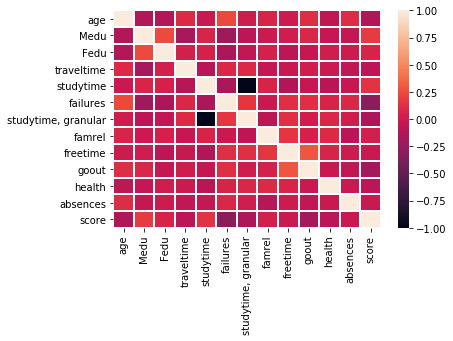

In [15]:
# построим тепловую диаграмму
sns.heatmap(corr, linewidths=1)

Выводы по общей таблице корреляций: данные stidytime и studytime, granular имеют 100%-ую отрицательную корреляцию, поэтому оставляем только один столбец stidytime. Смысл такой, чем меньше учебы в школе, тем ниже оценка и чем больше дополнительной учебы вне школы, тем выше оценка.

In [16]:
# удаляем лишний столбец 'studytime, granular'
st=st.drop('studytime, granular', axis=1)
st.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
0,18,4.0,4.0,2.0,2.0,0.0,4.0,3.0,4.0,3.0,6.0,30.0
1,17,1.0,1.0,1.0,2.0,0.0,5.0,3.0,3.0,3.0,4.0,30.0
2,15,1.0,1.0,1.0,2.0,3.0,4.0,3.0,2.0,3.0,10.0,50.0
3,15,4.0,2.0,1.0,3.0,0.0,3.0,2.0,2.0,5.0,2.0,75.0
4,16,3.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0


In [17]:
# посмотрим на характеристики данных
st.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
count,352.000000,350.000000,331.000000,329.000000,345.000000,332.000000,328.000000,344.000000,346.000000,339.000000,342.000000,352.000000
mean,16.633523,2.811429,2.658610,1.428571,2.046377,0.271084,3.942073,3.235465,3.086705,3.516224,8.090643,57.755682
std,1.256011,1.091192,2.324066,0.690907,0.840919,0.667779,0.921871,1.004258,1.091998,1.412812,24.704600,16.200928
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,20.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,2.000000,45.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


Беглый анализ данных позволяет увидеть, что в данных есть выбросы, например в Fedu и absences. Значит нужно проанализировать весь массив на выбросы. famrel по условиям не должно быть отрицательным.

In [18]:
# убираем явные отклонения
st=st[st.Fedu<=4]
st=st[st.absences<100]
st=st[st.famrel>0]

In [19]:
# поищем выбросы по всем полям с учетом межквартильного размаха
bb=[]
col_list=st.columns.tolist()
for i in col_list[:-1]:
    perc25 = st[i].quantile(0.25)
    perc75 = st[i].quantile(0.75)
    IQR = perc75-perc25
    gr_min = perc25-1.5*IQR
    gr_max = perc75+1.5*IQR
    if st[i].max() > gr_max or st[i].min() < gr_min:
        print(i, 'имеет выбросы')
    else:
        continue

age имеет выбросы
Fedu имеет выбросы
traveltime имеет выбросы
studytime имеет выбросы
failures имеет выбросы
famrel имеет выбросы
freetime имеет выбросы
absences имеет выбросы


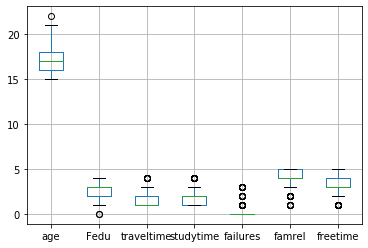

In [20]:
# рассмотрим эти выбросы на графике (без учета столбца absences, его рассмотрим отдельно)
st[['age','Fedu','traveltime','studytime','failures','famrel','freetime']].boxplot()

На графике видно, что у всех данных есть выбросы, но эти значения находятся в пределах референсных, поэтому считаю, чтоу далять их не нужно. Это говорит только о качестве распределения совокупности данных.

In [21]:
# расчет корреляции и p-value для каждого столбца со значениями столбца score
for i in col_list[:-1]:
    basa_1=st[[i,'score']]
    basa_1=basa_1.dropna()
    cor_1=pearsonr(basa_1[i],basa_1['score'])
    print(cor_1, 'корреляция для', i)

(-0.1295302331556805, 0.02584790226846146) корреляция для age
(0.17614944677292516, 0.002435807866366558) корреляция для Medu
(0.12747969859951716, 0.028313283291693202) корреляция для Fedu
(-0.08548318360623669, 0.1574470347646493) корреляция для traveltime
(0.14886258886984066, 0.011001272031263252) корреляция для studytime
(-0.26278129639148473, 8.666323263292714e-06) корреляция для failures
(0.04795766609452324, 0.4110331469554322) корреляция для famrel
(-0.012592687394140802, 0.8309151264093007) корреляция для freetime
(-0.18377492314342775, 0.0016730128454192834) корреляция для goout
(-0.033491657843970936, 0.574061571938805) корреляция для health
(-0.18083899640845702, 0.001784695022105372) корреляция для absences


### На основе вышеприведенных данных можно сделать следующие выводы: Значимые переменные: age, Medu, Fedu, studytime, failures, goout, absences. Выборка в данном случае произведена по значению p-value (второе значение в скобках). Чем ниже значение, тем выше качество корреляции. Граница отсечения 0,05.

## 4. Заполнение пробелов в выбранных переменных

In [22]:
# Выберем данные по нужным столбцам
st2=stud[['age', 'Medu', 'Fedu', 'studytime', 'failures', 'goout', 'absences', 'address', 'schoolsup', 'score']]
st2

,age,Medu,Fedu,studytime,failures,goout,absences,address,schoolsup,score
0,18,4.0,4.0,2.0,0.0,4.0,6.0,U,yes,30.0
1,17,1.0,1.0,2.0,0.0,3.0,4.0,U,no,30.0
2,15,1.0,1.0,2.0,3.0,2.0,10.0,U,yes,50.0
3,15,4.0,2.0,3.0,0.0,2.0,2.0,U,no,75.0
4,16,3.0,3.0,2.0,0.0,2.0,4.0,U,no,50.0
...,...,...,...,...,...,...,...,...,...,...
390,20,2.0,2.0,2.0,2.0,4.0,212.0,U,no,45.0
391,17,3.0,1.0,1.0,0.0,5.0,3.0,U,no,80.0
392,21,1.0,1.0,1.0,3.0,3.0,3.0,R,NaN,35.0
393,18,3.0,2.0,1.0,0.0,1.0,0.0,R,no,50.0


### Работа со столбцами: address и schoolsup

In [23]:
print(studd.groupby(['address'])['score'].mean())
print(studd['score'].mean())

address
R    53.356164
U    58.830189
Name: score, dtype: float64
57.75568181818182


У городских детей выше среднего по всей выборке и сильно выше средней оценки детей, живущих не в городе. Поэтому заполним пробелы следующим образом, если оценка выше среднего, то проставим город - U. Если оценка ниже среднего, то проставим - R. Одновременно заменим U на 1, R на 0.

In [24]:
mean_score=st2.score.mean()
st2=st2.copy()
for i in st2.index:
    if st2.loc[i,'address']=='U':
        st2.loc[i,'address']=1
    elif st2.loc[i,'address']=='R':
        st2.loc[i,'address']=0
    else:
        if st2.loc[i,'score']>mean_score:
            st2.loc[i,'address']=1
        else:
            st2.loc[i,'address']=0

In [25]:
st2['address'].value_counts()

1    273
0     79
Name: address, dtype: int64

In [26]:
# аналогично заменим пустые значения в поле schoolsup
print(studd.groupby(['schoolsup'])['score'].mean())

schoolsup
no     59.610169
yes    48.020833
Name: score, dtype: float64


In [27]:
for i in st2.index:
    if st2.loc[i,'schoolsup']=='yes':
        st2.loc[i,'schoolsup']=1
    elif st2.loc[i,'schoolsup']=='no':
        st2.loc[i,'schoolsup']=0
        continue
    else:
        if st2.loc[i,'schoolsup']>mean_score:
            st2.loc[i,'schoolsup']=0
        else:
            st2.loc[i,'schoolsup']=1

In [28]:
st2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        352 non-null    int64  
 1   Medu       350 non-null    float64
 2   Fedu       331 non-null    float64
 3   studytime  345 non-null    float64
 4   failures   332 non-null    float64
 5   goout      346 non-null    float64
 6   absences   342 non-null    float64
 7   address    352 non-null    object 
 8   schoolsup  352 non-null    object 
 9   score      352 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 35.5+ KB


### Работа со столбцами Fedu и Medu

In [29]:
print(st2.groupby(['Fedu'])['score'].mean())
st2['Fedu'].value_counts()

Fedu
0.0     65.000000
1.0     53.461538
2.0     57.819149
3.0     57.078652
4.0     61.250000
40.0    60.000000
Name: score, dtype: float64


2.0     94
3.0     89
4.0     80
1.0     65
0.0      2
40.0     1
Name: Fedu, dtype: int64

В столбце Fedu есть одно значение - 40, ему соответствует оценка 60. Кроме этого есть два значения 0, которым соответствует оценка 65. Если посмотреть на группировку, то видим, что чем выше образование отца, тем выше оценка ученика. Вопрос, что делать с этими тремя выбросами.Предполагаю, что 40 - это значение 4, заполненное с ошибкой, а 0 заменю на 4.

In [30]:
st2.loc[:,'Fedu']=st2.loc[:,'Fedu'].apply(lambda x: 4 if x>4 or x==0 else x)
st2.loc[:,'Fedu']=st2.loc[:,'Fedu'].apply(lambda x: x if x>0 else 2)

In [31]:
print(st2.groupby(['Medu'])['score'].mean())
st2['Medu'].value_counts()

Medu
0.0    65.000000
1.0    51.382979
2.0    56.363636
3.0    57.183908
4.0    61.640000
Name: score, dtype: float64


4.0    125
2.0     88
3.0     87
1.0     47
0.0      3
Name: Medu, dtype: int64

In [32]:
st2.loc[:,'Medu']=st2.loc[:,'Medu'].apply(lambda x: 4 if x==0 else x)
st2.loc[:,'Medu']=st2.loc[:,'Medu'].apply(lambda x: x if x>0 else 2)

In [33]:
st2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        352 non-null    int64  
 1   Medu       352 non-null    float64
 2   Fedu       352 non-null    float64
 3   studytime  345 non-null    float64
 4   failures   332 non-null    float64
 5   goout      346 non-null    float64
 6   absences   342 non-null    float64
 7   address    352 non-null    object 
 8   schoolsup  352 non-null    object 
 9   score      352 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 35.5+ KB


### Работа со столбцом absences

In [34]:
st2['absences'].value_counts()

0.0      74
2.0      60
4.0      52
6.0      30
8.0      20
10.0     17
12.0     12
14.0     12
3.0       7
16.0      7
7.0       6
5.0       5
18.0      5
20.0      4
22.0      3
9.0       3
1.0       3
15.0      2
13.0      2
11.0      2
25.0      1
54.0      1
385.0     1
26.0      1
56.0      1
24.0      1
212.0     1
21.0      1
75.0      1
30.0      1
19.0      1
38.0      1
40.0      1
23.0      1
17.0      1
28.0      1
Name: absences, dtype: int64

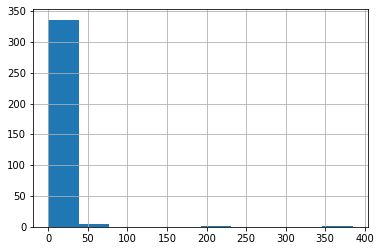

In [35]:
st2['absences'].hist()

Есть два аномально больших значения 385 и 212. Заменим эти два выброса на среднее значение без учета этих выбросов

In [36]:
mean_ab=st2[st2['absences']<100]['absences'].mean()
st2.loc[:,'absences']=st2.loc[:,'absences'].apply(lambda x: x if x<100 else mean_ab)

### Работа со столбцами studytime, failures, goout   

In [37]:
print(st2['studytime'].mean())
st2['studytime'].value_counts()

2.046376811594203


2.0    173
1.0     90
3.0     58
4.0     24
Name: studytime, dtype: int64

In [38]:
st2.loc[:,'studytime']=st2.loc[:,'studytime'].apply(lambda x: x if x>0 else 2)

In [39]:
print(st2.groupby(['failures'])['score'].mean())
print(st2['failures'].mean())
st2['failures'].value_counts()

failures
0.0    59.542125
1.0    50.526316
2.0    44.090909
3.0    41.500000
Name: score, dtype: float64
0.2710843373493976


0.0    273
1.0     38
2.0     11
3.0     10
Name: failures, dtype: int64

In [40]:
st2.loc[:,'failures']=st2.loc[:,'failures'].apply(lambda x: x if x>0 else 0)

In [41]:
print(st2.groupby(['goout'])['score'].mean())
print(st2['goout'].mean())
st2['goout'].value_counts()

goout
1.0    59.736842
2.0    61.467391
3.0    58.898305
4.0    54.189189
5.0    52.790698
Name: score, dtype: float64
3.086705202312139


3.0    118
2.0     92
4.0     74
5.0     43
1.0     19
Name: goout, dtype: int64

In [42]:
st2.loc[:,'goout']=st2.loc[:,'goout'].apply(lambda x: x if x>0 else 3)

In [43]:
# проверим, что данные не имеют пропусков
st2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        352 non-null    int64  
 1   Medu       352 non-null    float64
 2   Fedu       352 non-null    float64
 3   studytime  352 non-null    float64
 4   failures   352 non-null    float64
 5   goout      352 non-null    float64
 6   absences   352 non-null    float64
 7   address    352 non-null    object 
 8   schoolsup  352 non-null    object 
 9   score      352 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 35.5+ KB


## 5. Корреляционный анализ с учетом заполненных пробелов

In [44]:
# еще раз считаем корреляцию и p-value
col_2=st2.columns.tolist()
for i in col_2[:-1]:
    basa_2=st2[[i,'score']]
    cor_2=pearsonr(basa_2[i],basa_2['score'])
    print(cor_2, 'корреляция для', i)

(-0.13154198250524177, 0.013514729199821881) корреляция для age
(0.2090345016590381, 7.762201878366022e-05) корреляция для Medu
(0.13652179936318004, 0.010338945286843612) корреляция для Fedu
(0.13960519382905912, 0.008721946620374593) корреляция для studytime
(-0.28692467393145993, 4.2610113324366604e-08) корреляция для failures
(-0.1799128565133406, 0.0006959487545815839) корреляция для goout
(-0.20930892712009203, 7.591866107404308e-05) корреляция для absences
(0.15687043230183845, 0.0031677504267289634) корреляция для address
(-0.2607806869745593, 6.999214014138175e-07) корреляция для schoolsup


После заполнения пропусков корреляция сохранилась, значит заполнение было произведено корректно (можно попытаться еще улучшить качество замены, но сейчас тайкой задачи не стоит).

In [45]:
# посмотрим на попарную корреляцию еще раз
st2.corr()

,age,Medu,Fedu,studytime,failures,goout,absences,score
age,1.000000,-0.105612,-0.141865,-0.011270,0.236688,0.123597,0.206742,-0.131542
Medu,-0.105612,1.000000,0.561822,0.072538,-0.171366,0.061288,0.052103,0.209035
Fedu,-0.141865,0.561822,1.000000,0.011013,-0.266005,0.024690,0.021973,0.136522
studytime,-0.011270,0.072538,0.011013,1.000000,-0.147551,-0.029597,-0.077445,0.139605
failures,0.236688,-0.171366,-0.266005,-0.147551,1.000000,0.122500,0.128159,-0.286925
goout,0.123597,0.061288,0.024690,-0.029597,0.122500,1.000000,0.043646,-0.179913
absences,0.206742,0.052103,0.021973,-0.077445,0.128159,0.043646,1.000000,-0.209309
score,-0.131542,0.209035,0.136522,0.139605,-0.286925,-0.179913,-0.209309,1.000000


In [46]:
# проверим связь между Medu и Fedu
pearsonr(st2['Medu'],st2['Fedu'])

(0.5618224624815236, 1.1263466890108218e-30)

Безусловно связь между этими двумя показателями есть. Но говорить, что один из них можно убрать наверное нельзя. Скорее это говорит о предпочтениях в выборе пары при образовании семьи.

In [47]:
st2['Edu']=st['Medu']+st['Fedu']

In [48]:
st3=st2[['Edu','score']]
st3=st3.dropna()
pearsonr(st3['Edu'],st3['score'])

(0.1644228727474511, 0.0047057279028522945)

## 6. Выводы

Итоговый список столбцов для построения модели: score, age, (Medu и Fedu) в некоторой комбинации между собой, studytime, failures, goout, absences, address, schoolsup.
Выборка значимых столбцов:
Столбец score изначально содержал пустые значения. Их мы удаляем из-за высокой значимости. 
Столбцы age, studytime, failures содержат выбросы. Но они в пределах референтных значений, поэтому оставляем. 
Столбец absences содержит очень сильные выбросы (два значения 352 и 212), их убираем. 
При попарном сопоставлении выборка получается хорошей для анализа. 
Корреляция расчитана попарным сопоставлением со столбцом score c удалением пустых значений. Выборка этих переменных сделана с учетом значения p-value ниже 0,05. Из расчета убран столбец studytime, granular, так как он 100% коррелируется с переменной srudytime.
Далее, чтобы строить модель нужно иметь как можно большую выборку данных. Для этого преобразовываю данные путем замены выбросов и пустот на нужные значения. И получаю итоговые данные. Набор данных включает в себя 352 строки в соответствии с количеством непустых значений по полю score.